In [399]:
import numpy as np
import pandas as pd
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import gzip
import scipy.sparse as sparse
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (7.2,4.45)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['lines.markersize'] = 13
plt.style.use('seaborn-white')

### Paths to HTMs

In [400]:
path_models_ctm = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm_ctm")
path_models_mallet = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm")
path_models = path_models_mallet

### Get root models

In [401]:
dfs = []
for entry in path_models.iterdir():
    # check if it is a root model
    if "root" in entry.as_posix():
        thr = -1
        exp_tpc = -1
        iter_ = int(entry.as_posix().split("model_")[1].split("_")[0])
        path = entry
        cohrs = np.load(path.joinpath('TMmodel/topic_coherence.npy')).tolist()
        alphas = np.load(path.joinpath('TMmodel/alphas.npy')).tolist()
        tpc_ids = np.arange(0,len(alphas),1)
        if path.joinpath('corpus.txt').is_file():
            corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
            size = len(corpus)
        elif path.joinpath('corpus.parquet').is_dir():
            dfc = pd.read_parquet(path.joinpath('corpus.parquet'))
            size = len(dfc)
        root_tpc_df = pd.DataFrame(
            {'iter': [iter_] * len(alphas),
             'path': [path] * len(alphas),
             'cohrs': cohrs,
             'alphas': alphas,
             'tpc_ids': tpc_ids,
             'thr': [thr] * len(alphas),
             'exp_tpc': [exp_tpc] * len(alphas),
             'size': [size] * len(alphas),
             'tr_tpcs': [0] * len(alphas),
            })
        dfs.append(root_tpc_df)
df = pd.concat(dfs)
df = df.sort_values(by=['iter'])
df

,iter,path,cohrs,alphas,tpc_ids,thr,exp_tpc,size,tr_tpcs
4,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.704397,0.105999,4,-1,-1,61117,0
0,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.663815,0.136753,0,-1,-1,61117,0
1,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.627862,0.134788,1,-1,-1,61117,0
2,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.608068,0.127286,2,-1,-1,61117,0
3,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.811461,0.110195,3,-1,-1,61117,0
...,...,...,...,...,...,...,...,...,...
5,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.600878,0.089879,5,-1,-1,61117,0
6,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.671080,0.086353,6,-1,-1,61117,0
7,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.715144,0.083156,7,-1,-1,61117,0
9,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.722527,0.049645,9,-1,-1,61117,0


In [402]:
if df.iloc[0].path.joinpath('corpus.txt').is_file():
    corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                df.iloc[0].path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
    root_size = len(corpus)
elif df.iloc[0].path.joinpath('corpus.parquet').is_dir():
    dfc = pd.read_parquet(df.iloc[0].path.joinpath('corpus.parquet'))
    root_size = len(dfc)
root_size

61117

### Get submodels

In [403]:
# Iter over each root model (according to its corresponding iteration, iter)
concats = [df]
not_finished = []
for el in df.iter.unique():
    path_root = df[df.iter == el].iloc[0].path
    for entry in path_root.iterdir():
        if entry.joinpath('TMmodel/topic_coherence.npy').is_file():
        
            if "ws" in entry.as_posix():
                thr = 0
                size = 0
            else:
                thr = float(entry.as_posix().split("thr_")[1].split("_")[0])
                
                if entry.joinpath('corpus.txt').is_file():
                    corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                                entry.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                    size = len(corpus)
                elif entry.joinpath('corpus.parquet').is_dir():
                    dfc = pd.read_parquet(entry.joinpath('corpus.parquet'))
                    size = len(dfc)
                size = size * 100 / root_size

            # get topic from which the submodel is generated
            exp_tpc = int(entry.as_posix().split("from_topic_")[1].split("_")[0])

            # cohr submodel is the mean of the cohr of its topics
            cohr = np.mean(np.load(entry.joinpath('TMmodel/topic_coherence.npy')))
            #print(cohr)

            # cohr submodel is the mean of the cohr of its topics
            alpha = np.mean(np.load(entry.joinpath('TMmodel/alphas.npy')))
            
            tr_tpcs = int(entry.as_posix().split("train_with_")[1].split("_")[0])
            
            # add entry of submodel to dataframe
            root_tpc_df = pd.DataFrame(
            {'iter': [el],
             'path': [entry],
             'cohrs': [cohr],
             'alphas': [alpha],
             'tpc_ids': [exp_tpc],
             'thr': [thr],
             'exp_tpc': [exp_tpc],
             'size': [size],
             'tr_tpcs': [tr_tpcs]
            })
            concats.append(root_tpc_df)
        else:
            not_finished.append(entry)
df = pd.concat(concats)

### Generate graphs for root models

In [404]:
df_root = df[df.thr==-1]
df_root

,iter,path,cohrs,alphas,tpc_ids,thr,exp_tpc,size,tr_tpcs
4,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.704397,0.105999,4,-1.0,-1,61117.0,0
0,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.663815,0.136753,0,-1.0,-1,61117.0,0
1,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.627862,0.134788,1,-1.0,-1,61117.0,0
2,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.608068,0.127286,2,-1.0,-1,61117.0,0
3,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.811461,0.110195,3,-1.0,-1,61117.0,0
...,...,...,...,...,...,...,...,...,...
5,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.600878,0.089879,5,-1.0,-1,61117.0,0
6,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.671080,0.086353,6,-1.0,-1,61117.0,0
7,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.715144,0.083156,7,-1.0,-1,61117.0,0
9,9,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.722527,0.049645,9,-1.0,-1,61117.0,0


In [405]:
df1 = df_root.groupby('tpc_ids')[['cohrs']].mean()
df1 = df1.rename(columns={'cohrs': 'cohrs_mean'})

df2 = df_root.groupby('tpc_ids')[['cohrs']].var()
df2 = df2.rename(columns={'cohrs': 'cohrs_var'})

df3 = df_root.groupby('tpc_ids')[['alphas']].mean()
df3 = df3.rename(columns={'alphas': 'alphas_mean'})
df_root_plot = pd.concat([df1, df2, df3], axis=1, join='inner')

df_root_plot['tpc_ids'] = np.arange(0,len(df_root_plot),1)
df_root_plot

,cohrs_mean,cohrs_var,alphas_mean,tpc_ids
tpc_ids,,,,
0,0.675498,0.002493,0.138250,0
1,0.620522,0.000519,0.130660,1
2,0.658178,0.007068,0.124784,2
3,0.744955,0.006374,0.108842,3
4,0.663421,0.002132,0.100592,4
5,0.633516,0.008543,0.090083,5
6,0.690709,0.003512,0.085961,6
7,0.717010,0.001678,0.082737,7
8,0.681460,0.001783,0.075626,8


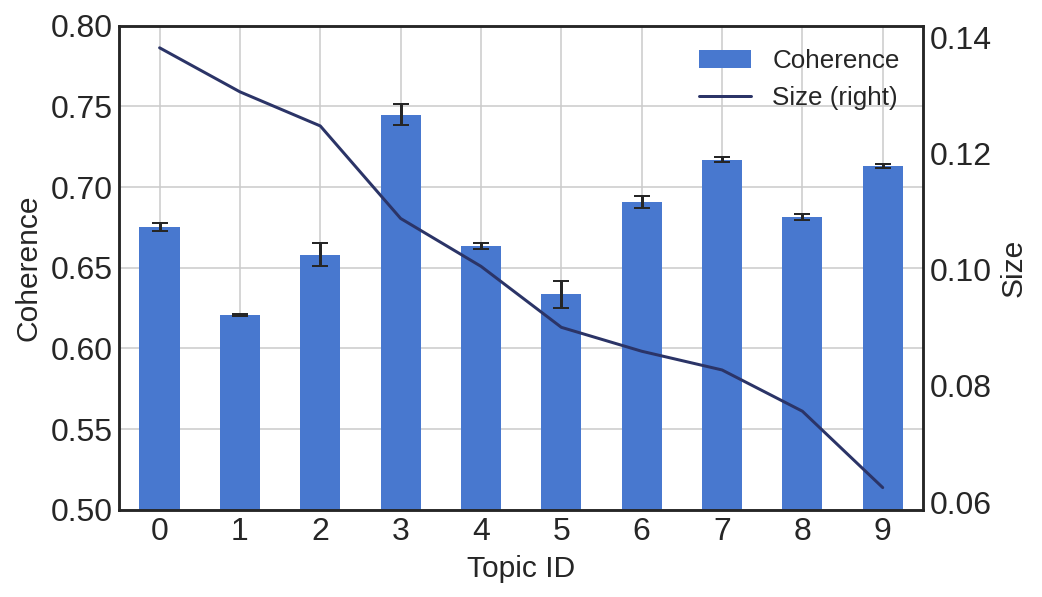

In [406]:
ax = df_root_plot.plot.bar(
        y='cohrs_mean',
        yerr = 'cohrs_var',
        label='Coherence', use_index=True, stacked=True,
        capsize=4)
ax2 = df_root_plot.plot(
        ax=ax, 
        y='alphas_mean', kind = 'line', label='Size', color="#2B3467", use_index=True, secondary_y=True)

ax.grid()
ax.set_xlabel('Topic ID')
ax.set_ylabel('Coherence')
ax.set_ylim([0.5, 0.8])
ax2.set_ylabel('Size')
plt.show()

### Get graphs for HTM-WS submodels

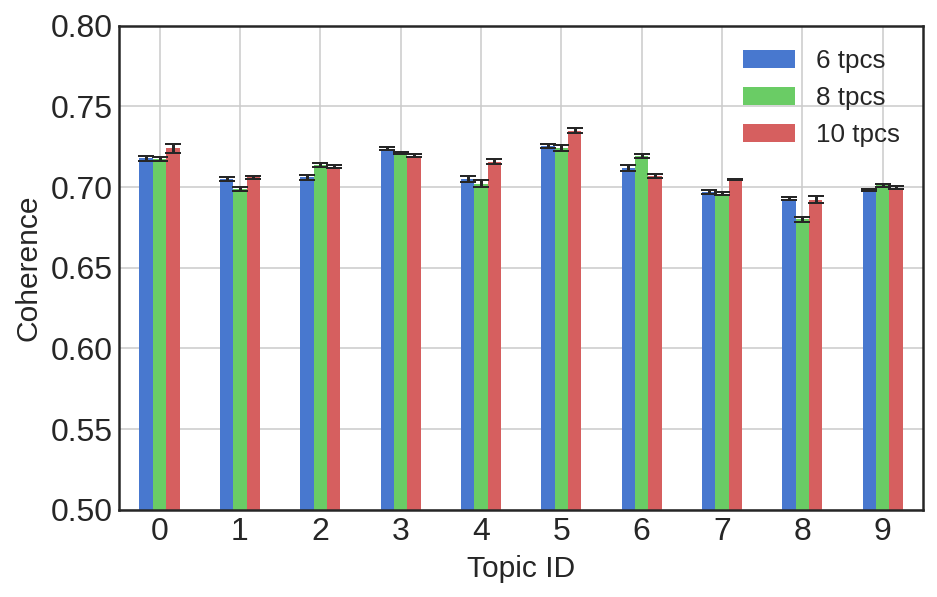

In [410]:
df_ws = df[df.thr==0]

concat = []
for el in df_ws.tr_tpcs.unique().tolist():
    
    df1 = df_ws[df_ws.tr_tpcs==el].groupby('exp_tpc')[['cohrs']].mean()
    df1 = df1.rename(columns={'cohrs': 'cohrs_mean' + "_" + str(el)})
    concat.append(df1)

    df2 = df_ws[df_ws.tr_tpcs==el].groupby('exp_tpc')[['cohrs']].var()
    df2 = df2.rename(columns={'cohrs': 'cohrs_var' + "_" + str(el)})
    concat.append(df2)

df_ws_plot = pd.concat(concat, axis=1, join='inner')
#df_ws_plot

aux = [df_ws_plot.cohrs_var_6.values.tolist(),
       df_ws_plot.cohrs_var_8.values.tolist(), 
       df_ws_plot.cohrs_var_10.values.tolist()]

ax = df_ws_plot.plot.bar(
        y=['cohrs_mean_6','cohrs_mean_8','cohrs_mean_10'],
        yerr = aux,
        label=['6 tpcs', '8 tpcs', '10 tpcs'], use_index=True,
        capsize=4)

ax.grid()
ax.set_xlabel('Topic ID')
ax.set_ylabel('Coherence')
ax.set_ylim([0.5, 0.8])
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.show()

In [408]:
prop_min = (600*100)/root_size
prop_max = 30

### Get graphs for HTM-DS submodels

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:40: Run

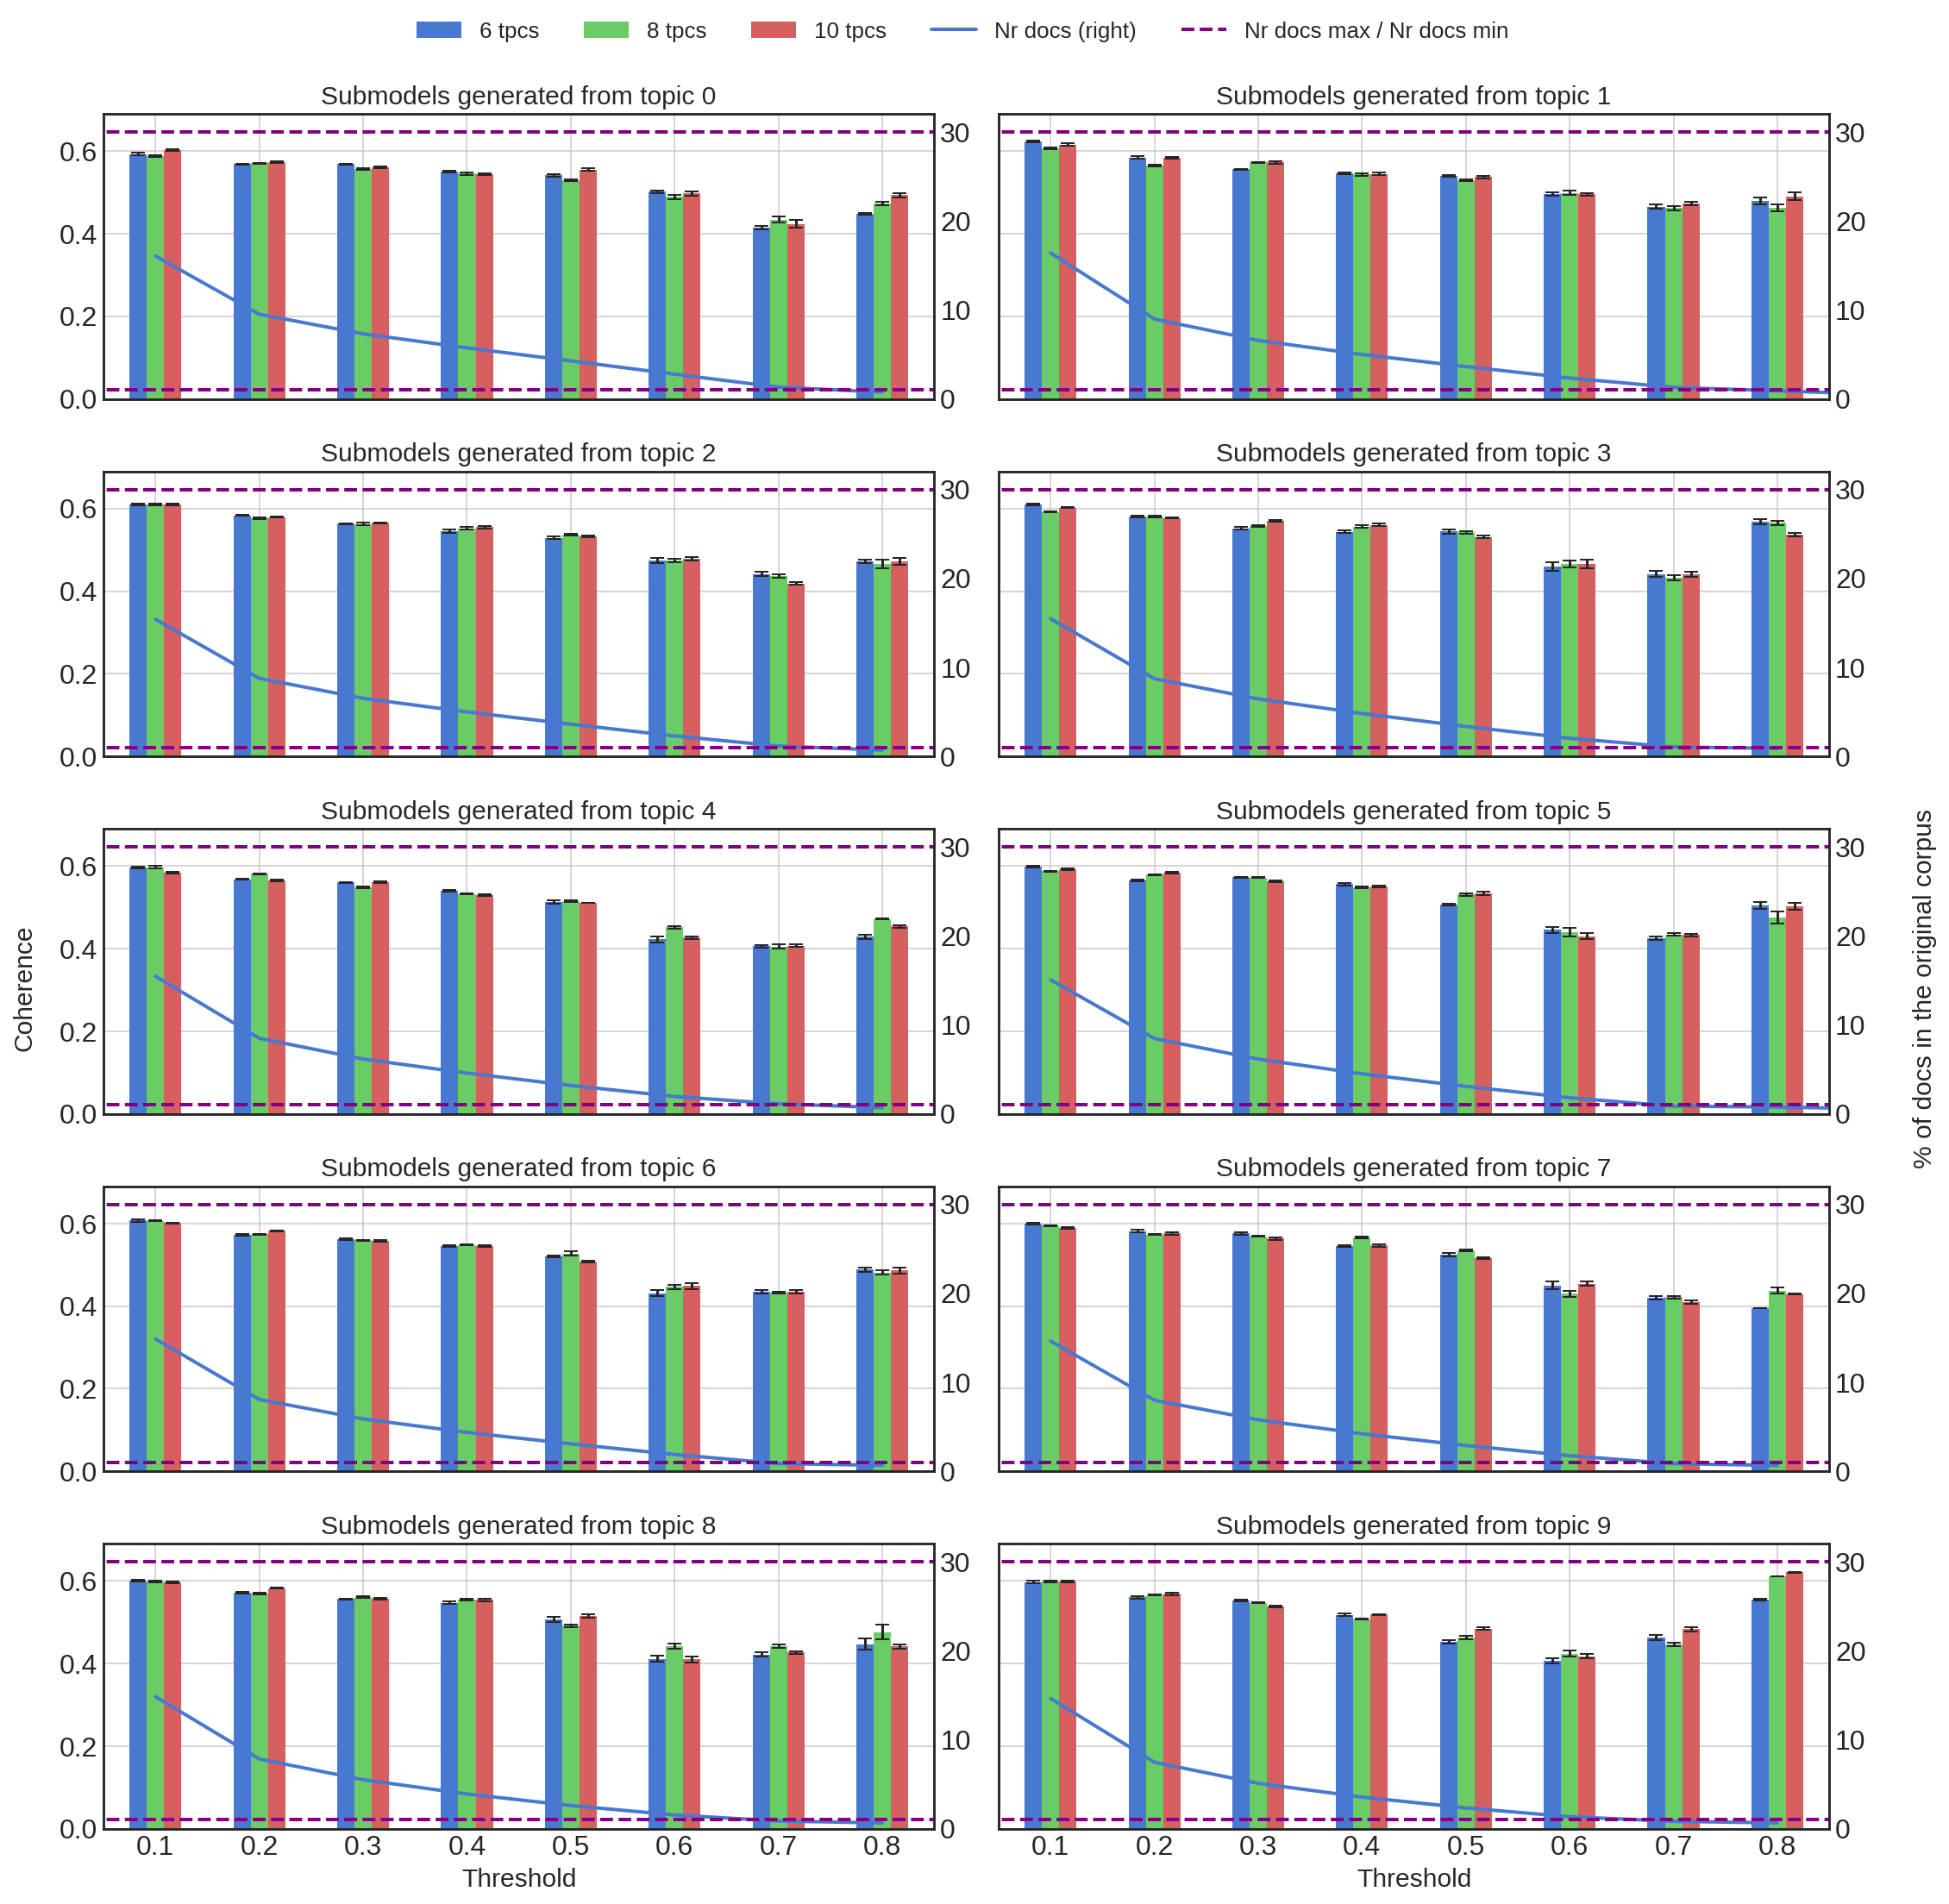

In [409]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize = (15, 15), sharex=True, sharey=True)

for tpc, ax in zip(df_ds_plot.exp_tpc.unique(), axs.flat):
    aux_df_ds = df_ds[df_ds.exp_tpc==tpc]
    concat = []
    for el in aux_df_ds.tr_tpcs.unique().tolist():

        df1 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[['cohrs','size']].mean()
        df1 = df1.rename(columns={'cohrs': 'cohrs_mean' + "_" + str(el),
                                  'size':  'size_mean' + "_" + str(el)})
        concat.append(df1)

        df2 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[['cohrs','size']].var()
        df2 = df2.rename(columns={'cohrs': 'cohrs_var' + "_" + str(el),
                                  'size':  'size_var' + "_" + str(el)})
        concat.append(df2)

    aux_df_ds_plot = pd.concat(concat, axis=1, join='inner').reset_index()

    aux = [aux_df_ds_plot.cohrs_var_6.values.tolist(),
           aux_df_ds_plot.cohrs_var_8.values.tolist(), 
           aux_df_ds_plot.cohrs_var_10.values.tolist()]

    aux_df_ds_plot.plot.bar(
            ax=ax,
            x='thr',
            y=['cohrs_mean_6','cohrs_mean_8','cohrs_mean_10'],
            yerr = aux,
            label=['6 tpcs', '8 tpcs', '10 tpcs'], use_index=True,
            capsize=4, rot=0)

    ax2 = aux_df_ds_plot.plot(
            ax=ax, 
            y='size_mean_6', 
            kind = 'line', 
            label='Nr docs', 
            secondary_y=True,
            linewidth=2)
    
    ax2.hlines(y=[prop_max,prop_min], xmin=-1, xmax=len(df_ds_plot.thr.unique()),
               colors='purple', linestyles='--', lw=2,
               label='Nr docs max / Nr docs min')
    ax2.set_ylim([0, 32])
    ax.set_xlabel('Threshold')
    ax.set_title(f'Submodels generated from topic {tpc}')
    ax.get_legend().remove()
    ax.grid()
    
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles+handles2, labels+labels2, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.03))
fig.text(-0.01, 0.5,'Coherence', va='center', rotation='vertical')
fig.text(1.01, 0.5,'% of docs in the original corpus', va='center', rotation='vertical')
fig.tight_layout()

### Get graphs for representations

In [419]:
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_preproc/iter_0")
topic_state_model = path_model.joinpath('modelFiles/topic-state.gz')

In [420]:
cohrs = np.load(path_model.joinpath('TMmodel/topic_coherence.npy')).tolist()
cohrs

[0.6178948685626796,
 0.5927233957290184,
 0.758894009770611,
 0.6813828498126884,
 0.6692079531931389,
 0.0674815190602734,
 0.05464392317204473,
 0.10472479435415646,
 0.09622414127338973,
 0.09759982110919224]

In [374]:
with gzip.open(topic_state_model) as fin:
    topic_state_df = pd.read_csv(fin, delim_whitespace=True,
                                 names=['docid', 'NA1', 'NA2',
                                        'NA3', 'word', 'tpc'],
                                 header=None, skiprows=3)

topic_state_df.word.replace('nan', np.nan, inplace=True)
topic_state_df.fillna('nan_value', inplace=True)

topic_state_df_tpc = topic_state_df[topic_state_df['tpc'] == 2]
topic_to_corpus = topic_state_df_tpc.groupby(
    'docid')['word'].apply(list).reset_index(name='new')

<BarContainer object of 5 artists>

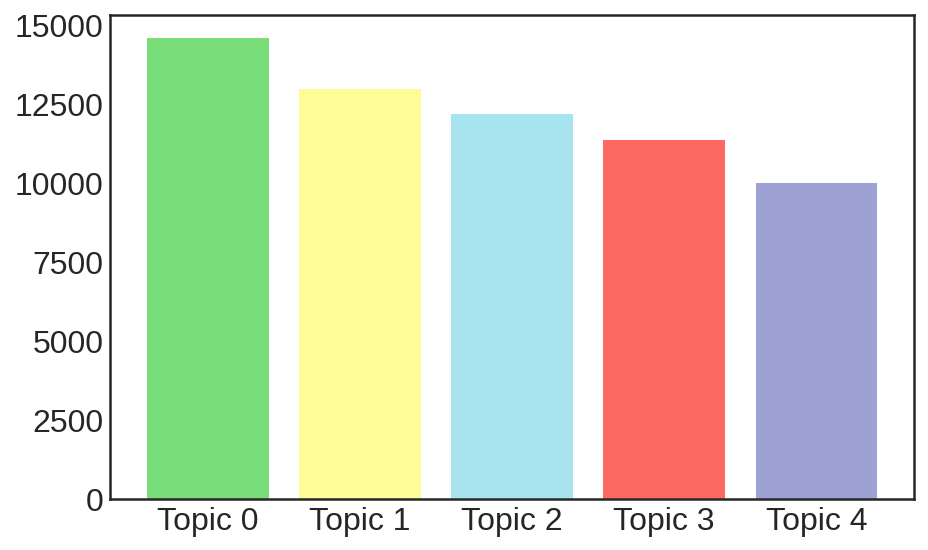

In [376]:
thetas = sparse.load_npz(
                path_model.joinpath('TMmodel/thetas.npz')).todense()
top_prop = np.sum(thetas,axis=0).tolist()[0]
aux = ["Topic 0","Topic 1","Topic 2","Topic 3","Topic 4"]
plt.bar(aux,top_prop, color = ['#79DE79', '#FCFC99', '#A8E4EF', '#FB6962','#9EA1D4'])

In [377]:
topic_to_corpus.iloc[0:20]

,docid,new
0,0,"[modern, guinea, country, december, individual..."
1,1,[identify]
2,3,"[evolution, unprecedented, anthropogenic_forci..."
3,4,"[mediterranean_region, strategic, improve, pro..."
4,7,"[personal, advisor, large_scale, past, informa..."
5,8,"[audio_visual, analyse, judgement, comparative..."
6,9,"[determinant, security, determinant, quantify]"
7,11,"[tangible, national, country, field, protectio..."
8,13,"[environment, rate, major, repercussion, long_..."
9,14,"[join, ecophysiological, ecosystem, land, atmo..."


In [397]:
topic_state_df[topic_state_df.docid==4]

,docid,NA1,NA2,NA3,word,tpc
381,4,nan_value,0,277,sustainability,0
382,4,nan_value,1,278,water,0
383,4,nan_value,2,279,secure,0
384,4,nan_value,3,280,food,0
385,4,nan_value,4,281,production,0
...,...,...,...,...,...,...
495,4,nan_value,114,345,agriculture,0
496,4,nan_value,115,346,meet,0
497,4,nan_value,116,120,future,2
498,4,nan_value,117,347,constraint_impose,0


In [382]:
thetas_2 = thetas[:,2]
np.argwhere(thetas_2 < 0.6)
#np.argwhere(thetas_2 > 0.6)[0:20]

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [11,  0],
       [12,  0],
       [13,  0],
       [14,  0],
       [15,  0],
       [16,  0],
       [17,  0],
       [19,  0],
       [20,  0],
       [21,  0],
       [22,  0]])

<BarContainer object of 5 artists>

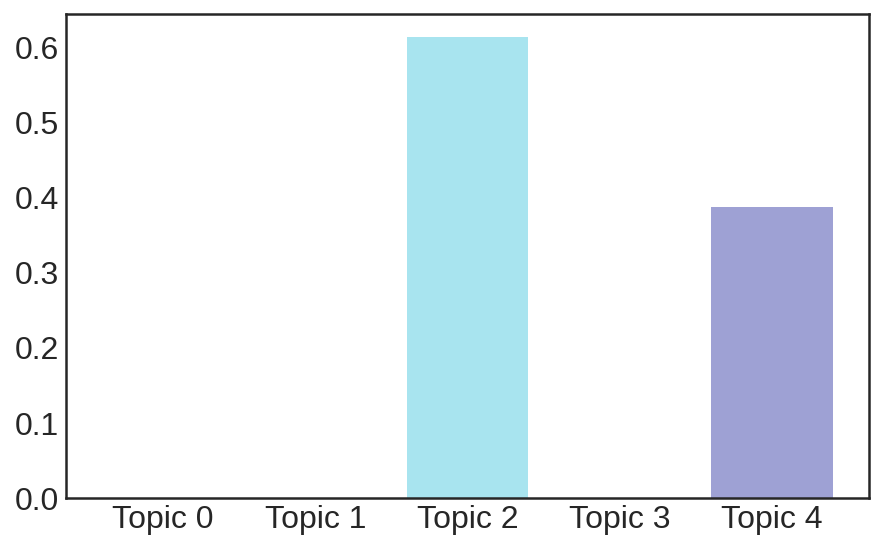

In [381]:
doc_id_1 = 4

aux = ["Topic 0","Topic 1","Topic 2","Topic 3","Topic 4"]
plt.bar(aux,thetas[4].tolist()[0], color = ['#79DE79', '#FCFC99', '#A8E4EF', '#FB6962','#9EA1D4'])

<BarContainer object of 5 artists>

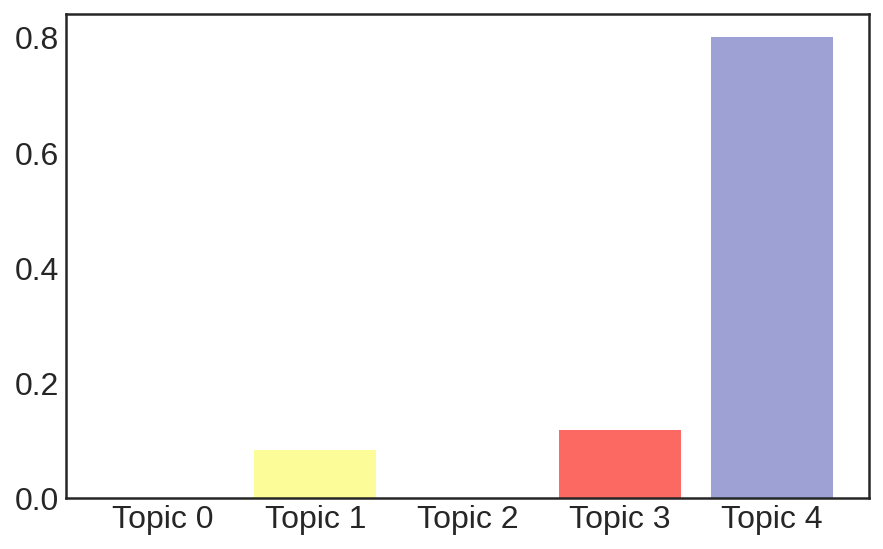

In [385]:
doc_id_1 = 3

aux = ["Topic 0","Topic 1","Topic 2","Topic 3","Topic 4"]
plt.bar(aux,thetas[3].tolist()[0], color = ['#79DE79', '#FCFC99', '#A8E4EF', '#FB6962','#9EA1D4'])